## Постановка задачи
Компания хочет **автоматизировать** процесс оценки кредитоспособности (в режиме реального времени) на основе данных клиента, предоставленных при заполнении онлайн-заявки. Для этого она опубликовала этот набор данных, который включает **615 строк** и **13 столбцов**.

**Названия столбцов с пояснением:**
 - **Loan_ID:**	 Id кредита
 - **Gender:**	 Пол заявителя
 - **Married:**	 Семейное положение заявителя
 - **Dependents:**	 Число членов семьи
 - **Education:**	 Образование (Graduate - есть образование, Not graduate - без образования)
 - **Self_Employed:**	 Статус занятости заявителя (YES - самозанятый, NO - не самозанятый)
 - **ApplicantIncome:**	 Месячный доход
 - **CoapplicantIncome:** Месячный доход второго заявителя
 - **LoanAmount:**	Размер кредита
 - **Loan_Amount_Term:** Срок погашения кредита (в днях)
 - **Credit_History:**	 Записи в кредитной истории (0 - был просроченный кредит, 1 - был вовремя выплаченный кредит, пропуск - нет данных)
 - **Property_Area:**	 Расположение недвижимости (Urban - в городе, Semiurban - в пригороде, Rural - сельская местность)
 - **Loan_Status:**	 Статус кредита (Y - одобрен, N - отклонен). **ТАРГЕТ**

## Импорт основных библиотек

In [1]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import helper as h
import random

In [3]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

##  1. Изучение структуры данных

In [4]:
# Загружаем датасет в память
df = pd.read_csv("data.csv")
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
# Смотрим на детали
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Здесь мы можем увидеть кол-во строк и столбцов, названия всех столбцов, их тип, ко-во значений в каждом (непропущенных). Пропущенные значения наблюдаются в столбцах Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term, Credit_History, поскольку кол-во значений в этих столбцах < 614

In [6]:
# Смотрим на статистики по числовым переменным (категориальные сюда не входят)
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## 2. Проверка на корректность и качество данных

### 2.1 Проверка на дубликаты

In [7]:
# Подсчет числа дублированных строк
df.duplicated().sum() 

np.int64(0)

Дубликатов в датасете нет

### 2.2 Пропущенные значения

In [8]:
# выводим число пропущенных значений по каждому столбцу
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
# выводим долю пропущенных значений от общего числа значений по каждому столбцу
df.isnull().mean().round(4)

Loan_ID              0.0000
Gender               0.0212
Married              0.0049
Dependents           0.0244
Education            0.0000
Self_Employed        0.0521
ApplicantIncome      0.0000
CoapplicantIncome    0.0000
LoanAmount           0.0358
Loan_Amount_Term     0.0228
Credit_History       0.0814
Property_Area        0.0000
Loan_Status          0.0000
dtype: float64

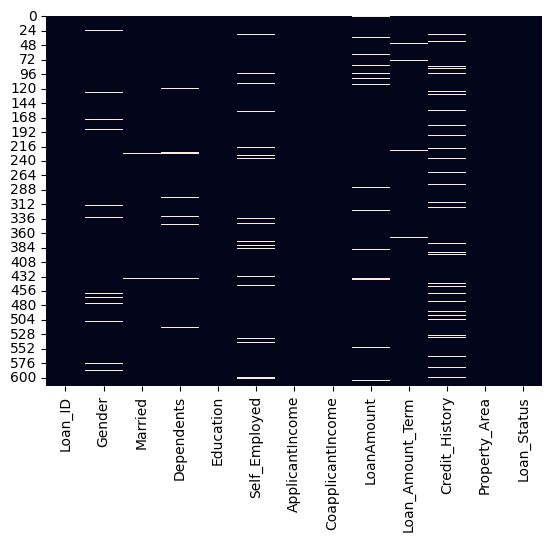

In [10]:
# Тепловая карта пропусков. Наглядно показывает, в каких частях датасета пропущенные значения
sns.heatmap(df.isnull(), cbar=False);

### 2.3 Корректность по столбцам

In [11]:
# Убедимся, что только 2 значения Gender
df['Gender'].value_counts()

Gender
Male      489
Female    112
Name: count, dtype: int64

In [12]:
# Убедимся, нет отрицательных значений ApplicantIncome 
len(df[df['ApplicantIncome'] < 0])

0

In [13]:
# Убедимся, нет отрицательных значений CoapplicantIncome 
len(df[df['CoapplicantIncome'] < 0])

0

In [14]:
# Убедимся, что только 2 значения Self_Employed
df['Self_Employed'].value_counts()

Self_Employed
No     500
Yes     82
Name: count, dtype: int64

In [15]:
# Убедимся, что только 3 значения Property_Area
df['Property_Area'].value_counts()

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64

In [16]:
df['Education'].value_counts()

Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64

## 3. Детальное изучение признаков (и таргета)

Примечание: по хорошему стоит также учесть пропущенные значения при построении графиков, предварительно заменив их на константу, чтобы видеть более общую картину, но поскольку в этом датасете максимальная их доля в столбце составляет 8%, мы пропустим этот шаг

### 3.1 Числовые переменные

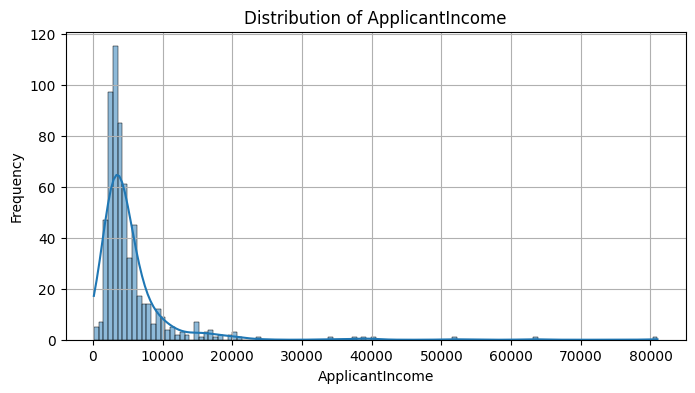

In [17]:
# Строим гистограмму распределения ApplicantIncome
h.plot_hist_numeric(df, 'ApplicantIncome')

Видим, что основная масса значений находится в диапазоне 0 - 20000. Все остальное - выбросы

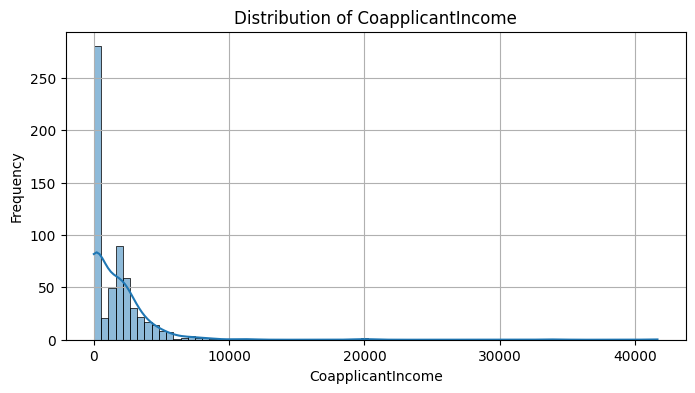

In [18]:
# Строим гистограмму распределения CoapplicantIncome
h.plot_hist_numeric(df, 'CoapplicantIncome')

Видим, что основная масса значений находится в диапазоне 0 - 10000, при этом большая часть значений в 0. Это говорит о том, что большинство людей подавали заявку одни. Все остальное - выбросы

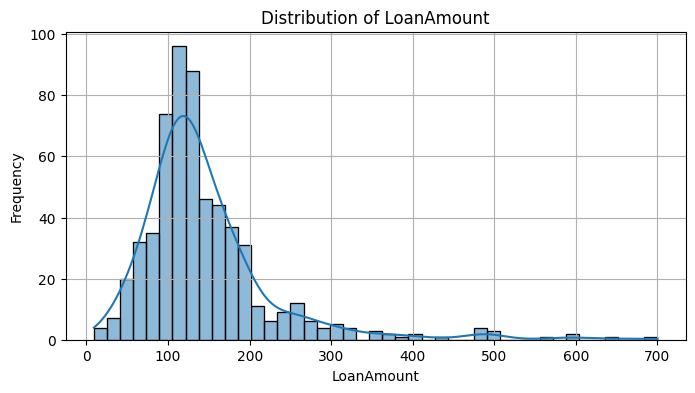

In [19]:
# Строим гистограмму распределения LoanAmount
h.plot_hist_numeric(df, 'LoanAmount')

Видим, что основная масса значений находится в диапазоне 0 - 300, при этом есть суммы кредитов, близкие к 0, что подозрительно, имеет смысл изучить детальнее. Все остальное - выбросы

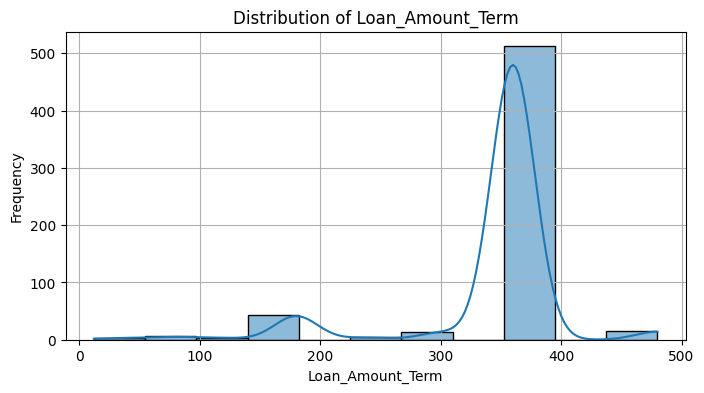

In [20]:
# Строим гистограмму распределения Loan_Amount_Term
h.plot_hist_numeric(df, 'Loan_Amount_Term')

In [21]:
df['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

Видим, что:
- Количество дней в основном круглое, что говорит о привязке к месяцам. Имеет смысл сделать преобразование числа дней в число месяцев (разделить на 30)
- Наблюдается дисбаланс. Имеет смысл объединить мелкие категории в одну крупную т.к. особой информативности эти значения не несут

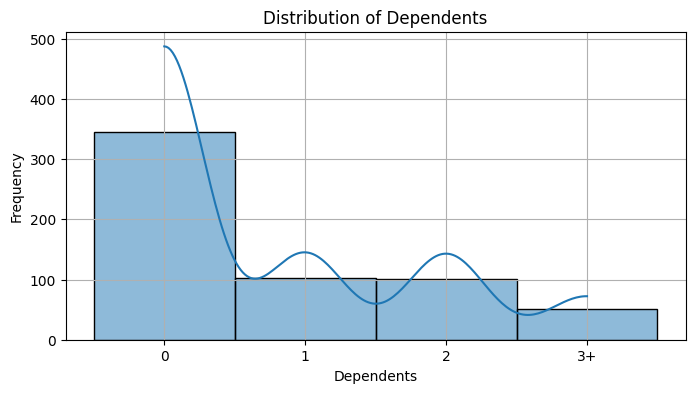

In [22]:
# Строим гистограмму распределения Dependents
h.plot_hist_numeric(df, 'Dependents')

Видим, что у большинства клиентов нет иждивенцев (того, кого они содержат)

### 3.2 Категориальные переменные

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


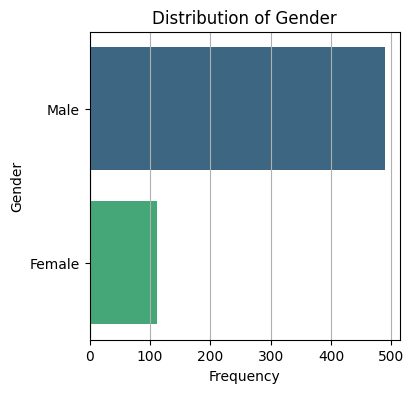

In [23]:
# Строим гистограмму распределения Gender
h.plot_hist_categorical(df, 'Gender')

Большинство клиентов - мужчины

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


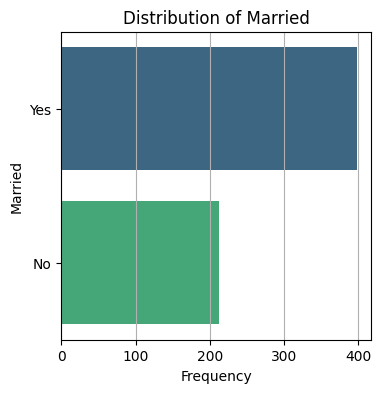

In [24]:
# Строим гистограмму распределения Married
h.plot_hist_categorical(df, 'Married')

2/3 клиентов женаты или замужем

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


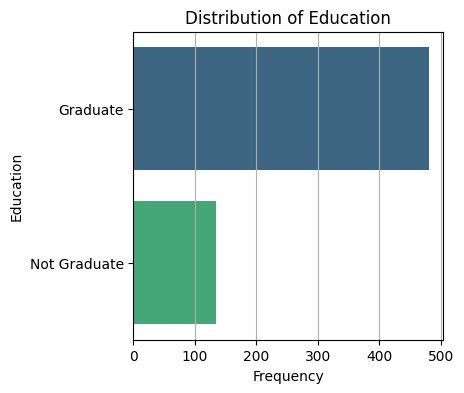

In [25]:
# Строим гистограмму распределения Education
h.plot_hist_categorical(df, 'Education')

Большинство клиентов имеет высшее образование

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


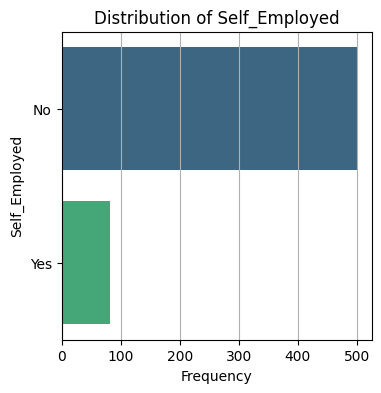

In [26]:
# Строим гистограмму распределения Self_Employed
h.plot_hist_categorical(df, 'Self_Employed')

Только малая часть клиентов работает на себя, большинство - на наемной работе

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


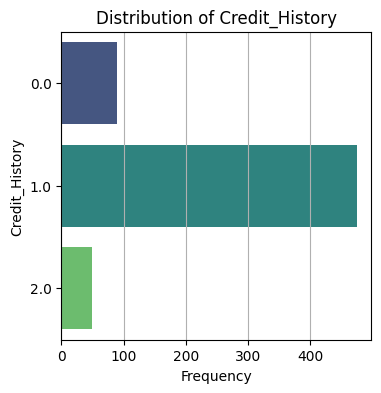

In [27]:
# Для наглядности преобразуем пропущенные значения в 2
df['Credit_History'] = df['Credit_History'].fillna(2)

# Строим гистограмму распределения Credit_History
h.plot_hist_categorical(df, 'Credit_History')

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


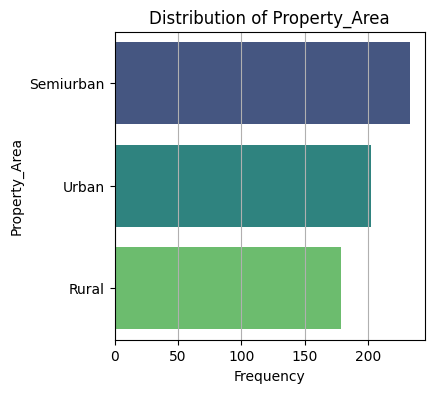

In [28]:
# Строим гистограмму распределения Property_Area
h.plot_hist_categorical(df, 'Property_Area')

Варианты расположения недвижимости довольно сбалансированны

c:\YandexDisk\IT\DS\loan-prediction\helper.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis", orient='h')


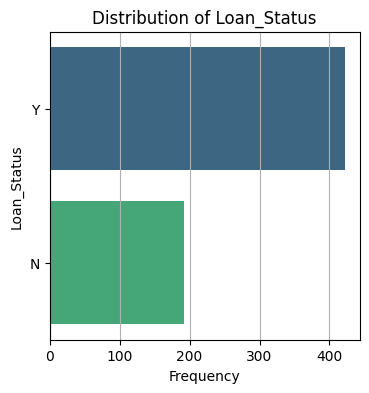

In [29]:
# Строим гистограмму распределения Loan_Status (это наш таргет)
h.plot_hist_categorical(df, 'Loan_Status')

только в 1/3 случаях кредит оказывается неодобрен. Имеем дело с несбалансированным датасетом. Необходимо применить техники балансировки

## 4. Изучение взаимосвязей между признаками

### 4.1 Общая матрица корреляций

Наша цель состоит в том, чтобы понять, какие столбцы коррелируют друг с другом наиболее сильно и далее изучить подробнее эти корреляции. также понять, какие из столбцов сильнее всего коррелируют с таргетом

In [30]:
# удаляем столбец Loan_ID, поскольку он не несет пользы в дальнейшем исследовании
df = df.drop(columns=['Loan_ID'])

interval columns not set, guessing: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


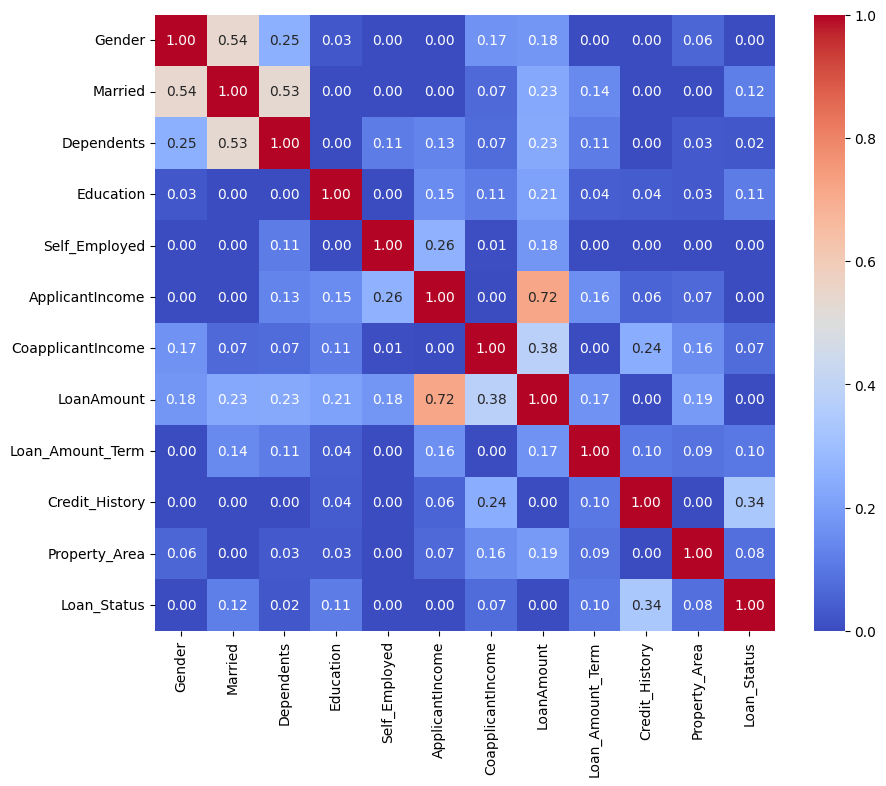

In [31]:
# поскольку в нашем датасете присутствуют категориальные признаки, используем корреляцию phik, которая способна с ними работать
h.plot_phik(df)

Обращаем внимание на ячейки с более высокими значениями корреляции. Видим, что наиболее сильные связки это: 
- Married vs Gender
- LoanAmount vs ApplicantIncome
- LoanAmount vs CoapplicantIncome
- Credit_History vs Loan_Status
- Self_Employed vs ApplicantIncome

### 4.2 Подробное изучение корреляций между выбранными парами

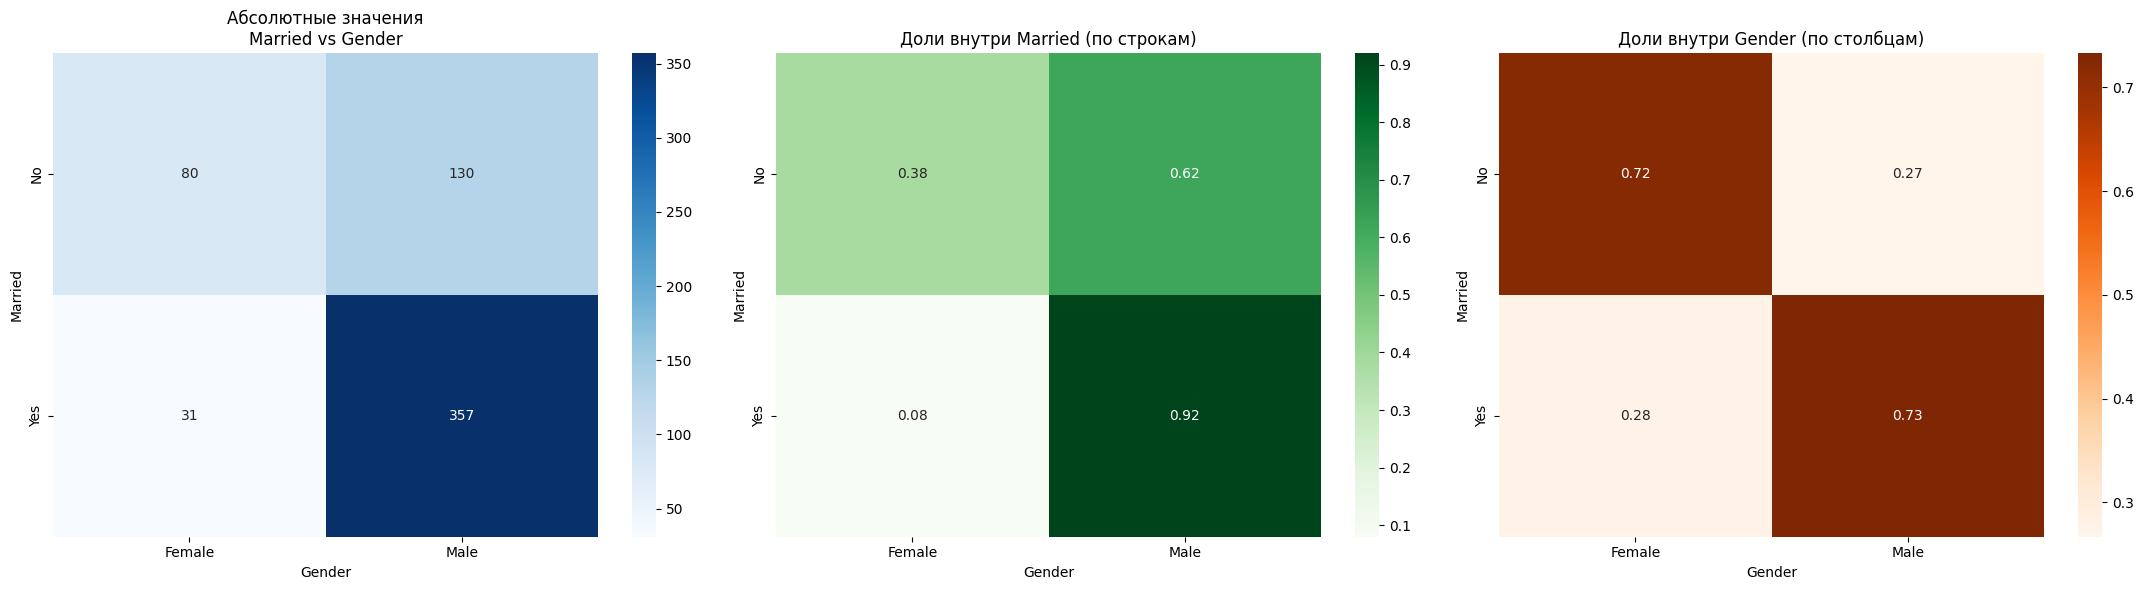

In [32]:
h.plot_categorical_relationship(df, 'Married', 'Gender')

Видим интересную зависимость замужества от пола: 73% мужчин женаты, в то время как только 28% женщин замужем

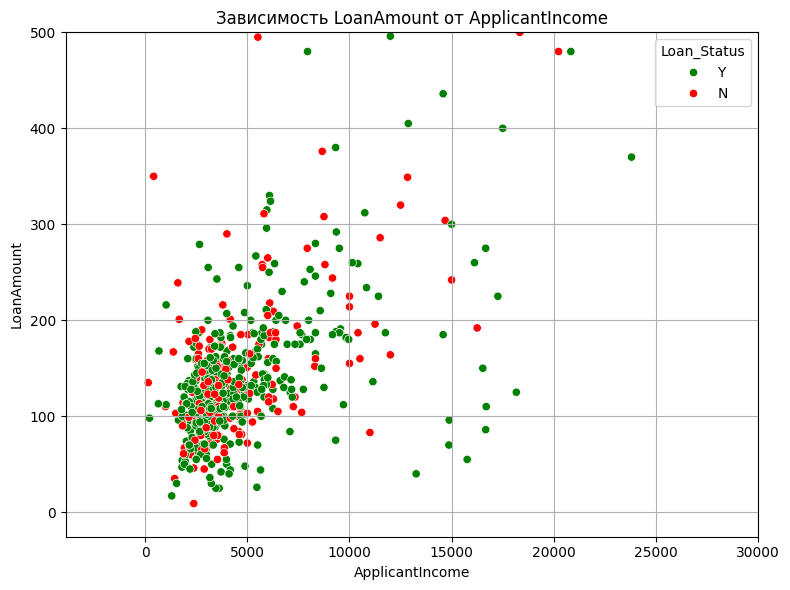

In [33]:
h.plot_numeric_relationship(
    df, 
    'ApplicantIncome', 
    'LoanAmount', 
    x_max=30000,
    y_max=500,
    target_col='Loan_Status', 
    target_colors={'Y': 'green', "N": 'red'}
)

Четкой линейной зависимости размера кредита от дохода не видно, как и зависимоcти таргета от этих двух признаков

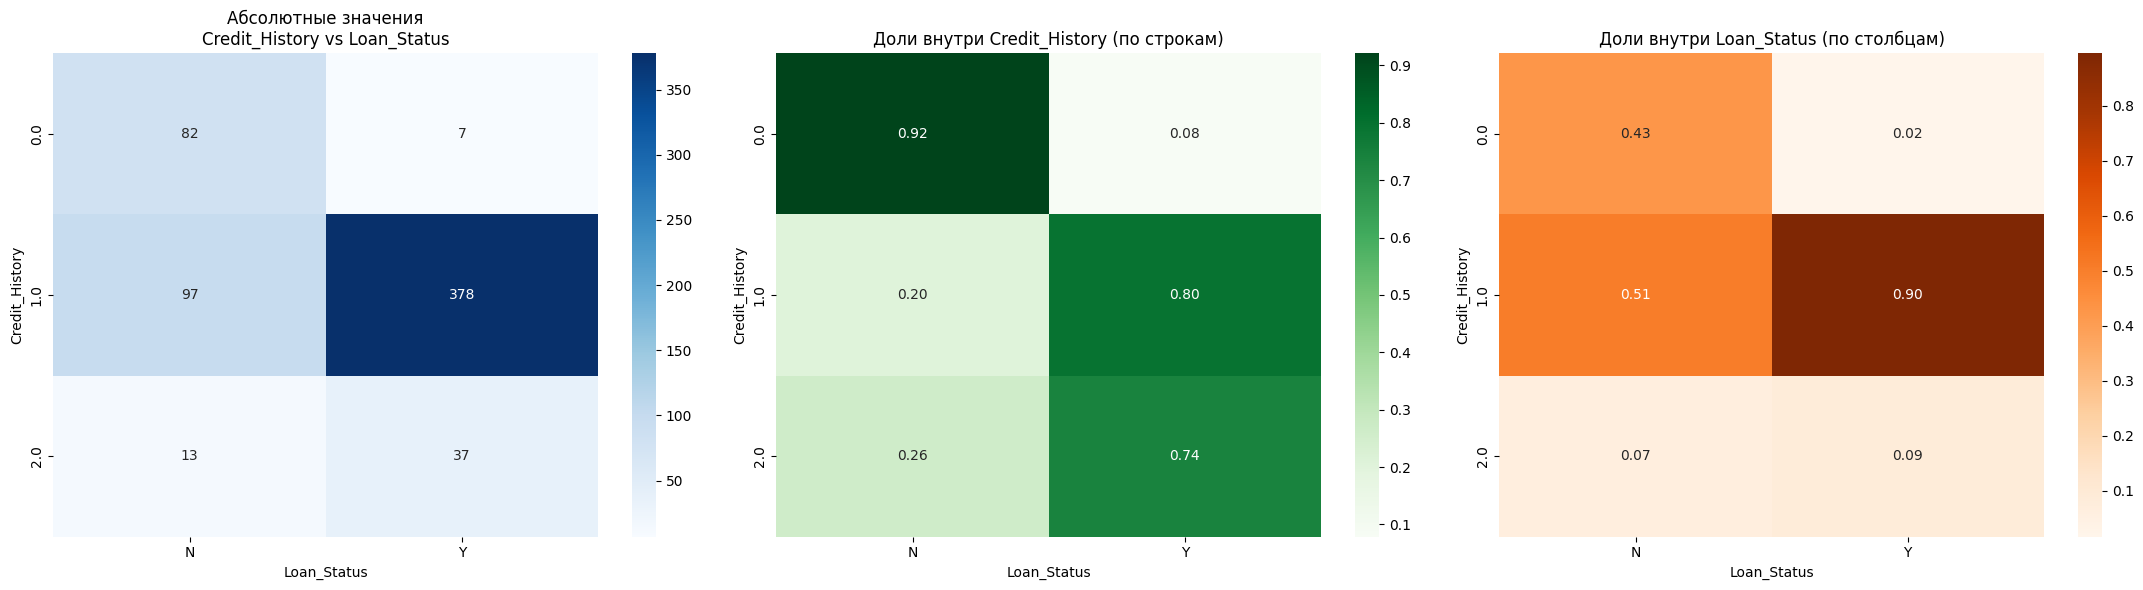

In [34]:
h.plot_categorical_relationship(df, 'Credit_History', 'Loan_Status')

Здесь видна четкая зависимость между кредитной историей и таргетом. Если клиент в прошлом просрочил кредит, то ему отказывают в 92% случаев, если же отдал в срок, то в 80% случаев одобряют. Если нет данных, то одобряют в 74% случаев

## 5. Препроцессинг данных
Препроцессинг данных можно разделить на **две основные категории**:
1. **Общие преобразования** – применяются ко всему датасету до разделения на train и test.
2. **Индивидуальные преобразования** – выполняются отдельно для тренировочной и тестовой выборок.

## Почему такое разделение необходимо?

Некоторые преобразования требуют **расчета статистик** (например, замена пропусков медианой, стандартизация, частотное кодирование) или даже **обучения вспомогательных моделей** (например, KNN для импутации пропущенных значений). Если применить такие преобразования ко всему датасету **до** разделения, это приведет к **data leakage** (утечке данных).

### Что такое data leakage и чем он опасен?

Data leakage возникает, когда информация из тестового набора **неявно влияет** на preprocessing тренировочных данных (например, при расчете среднего или обучении encoder'а). В результате:
- Модель получает доступ к данным, которых не должно "знать" в реальных условиях.
- Оценки качества становятся **завышенными**, но на новых данных модель работает хуже.

### Как избежать утечки данных?

1. **Сначала разделять данные** на train и test (или использовать кросс-валидацию).
2. **Обучать preprocessing-алгоритмы** (импутеры, энкодеры, скейлеры) **только на train**.
3. **Применять обученные преобразования** к test, **без пересчета статистик**.

Для удобства можно использовать **пайплайны** (например, `sklearn.pipeline.Pipeline`), которые автоматически следят за корректным порядком преобразований.

## Какие преобразования можно применять ко всему датасету?

Те, что **не зависят от статистик** и не требуют обучения:
- Удаление дубликатов.
- Исправление очевидных аномалий (например, отрицательный возраст).
- Разовые преобразования (изменение формата даты, переименование столбцов).
- Фильтрация строк/столбцов, не связанная с целевой переменной.

Такой подход помогает **избежать дублирования кода**, сохраняя при этом валидность эксперимента.

### 5.1 Общие преобразования

In [35]:
df_preprocessed = df.copy()

In [36]:
# Заменяем категорию 3+ на 3, чтобы это не ломало модель
df_preprocessed['Dependents'] = np.where(df_preprocessed['Dependents'] == '3+', 3, df_preprocessed['Dependents'])

In [37]:
# преобразуем в числовой тип, поскольку признак числовой
df_preprocessed['Dependents'] = pd.to_numeric(df_preprocessed['Dependents'])

In [38]:
df_preprocessed['Dependents'].unique()

array([ 0.,  1.,  2.,  3., nan])

In [39]:
# Кодирование таргета
df_preprocessed['Loan_Status'] = np.where(df_preprocessed['Loan_Status'] == 'Y', 1, 0)

In [40]:
# преобразуем в числовой тип, поскольку признак числовой
df_preprocessed['Loan_Amount_Term'] = pd.to_numeric(df_preprocessed['Loan_Amount_Term'])

In [41]:
# Убеждаемся, что типы признаков сохранились как нам нужно
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    float64
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 57.7+ KB


### 5.2 Разбиение датасета 

In [42]:
# делим данные на признаки и таргет
X, y = h.divide_data(df_preprocessed, 'Loan_Status')

In [43]:
# разбиваем данные на train и test с соотношением 80 на 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [44]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
83,Male,Yes,0.0,Graduate,No,6000,2250.0,265.0,360.0,2.0,Semiurban
90,Male,Yes,0.0,Graduate,No,2958,2900.0,131.0,360.0,1.0,Semiurban
227,Male,Yes,2.0,Graduate,No,6250,1695.0,210.0,360.0,1.0,Semiurban
482,Male,Yes,0.0,Graduate,No,2083,3150.0,128.0,360.0,1.0,Semiurban
464,Male,No,0.0,Graduate,No,4166,0.0,98.0,360.0,0.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
71,Male,Yes,2.0,Not Graduate,Yes,1875,1875.0,97.0,360.0,1.0,Semiurban
106,Male,Yes,2.0,Graduate,No,11417,1126.0,225.0,360.0,1.0,Urban
270,Female,No,0.0,Graduate,No,3237,0.0,30.0,360.0,1.0,Urban
435,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban


In [45]:
X_train_preprocessed = X_train.copy()

In [46]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numeric_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

### 5.1 Обработка пропущенных значений

In [47]:
# пропуски в этих колонках будут заполняться наиболее частыми значениями
most_frequent_numeric_cols = ['Dependents', 'Loan_Amount_Term']
most_frequent_cat_cols = ['Gender', 'Married', 'Self_Employed']

# пропуски в этих колонках будут заполняться медианой
mean_imputer_cols = ['LoanAmount']

In [48]:
# заменяем пропуски на самое частое значение
most_frequent_inputer = SimpleImputer(strategy='most_frequent')

# обрабатываем числовые и категориальные колонки отдельно, чтобы избежать ошибок с типами данных в дальнейшем
X_train_preprocessed[most_frequent_numeric_cols] = most_frequent_inputer.fit_transform(X_train_preprocessed[most_frequent_numeric_cols])
X_train_preprocessed[most_frequent_cat_cols] = most_frequent_inputer.fit_transform(X_train_preprocessed[most_frequent_cat_cols])


In [49]:
# Убеждаемся, что типы данных не поменялись
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 83 to 102
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             491 non-null    object 
 1   Married            491 non-null    object 
 2   Dependents         491 non-null    float64
 3   Education          491 non-null    object 
 4   Self_Employed      491 non-null    object 
 5   ApplicantIncome    491 non-null    int64  
 6   CoapplicantIncome  491 non-null    float64
 7   LoanAmount         475 non-null    float64
 8   Loan_Amount_Term   491 non-null    float64
 9   Credit_History     491 non-null    float64
 10  Property_Area      491 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 46.0+ KB


In [50]:
# заменяем пропуски на медиану
mean_imputer = SimpleImputer(strategy='mean')
X_train_preprocessed[mean_imputer_cols] = most_frequent_inputer.fit_transform(X_train_preprocessed[mean_imputer_cols])

In [51]:
# убедимся, что пропусков больше нет
X_train_preprocessed.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

### 5.2 Кодирование категориальных переменных

In [52]:
# Будем использовать порядковое кодирование. Для этого выпишем все категории для каждого столбца в порядке увеличения номера
category_orders = [
    ['Male', 'Female'], # gender
    ['No', 'Yes'], # married                         
    ['Not Graduate', 'Graduate'], # education    
    ['No', 'Yes'], # self employed
    ['Rural', 'Semiurban', 'Urban'] # property area        
]

encoder = OrdinalEncoder(categories=category_orders)
X_train_preprocessed[categorical_cols] = encoder.fit_transform(X_train_preprocessed[categorical_cols])

In [53]:
# посмотрим на результат работы кодировщика
X_train_preprocessed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
83,0.0,1.0,0.0,1.0,0.0,6000,2250.0,265.0,360.0,2.0,1.0
90,0.0,1.0,0.0,1.0,0.0,2958,2900.0,131.0,360.0,1.0,1.0
227,0.0,1.0,2.0,1.0,0.0,6250,1695.0,210.0,360.0,1.0,1.0
482,0.0,1.0,0.0,1.0,0.0,2083,3150.0,128.0,360.0,1.0,1.0
464,0.0,0.0,0.0,1.0,0.0,4166,0.0,98.0,360.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,1.0,2.0,0.0,1.0,1875,1875.0,97.0,360.0,1.0,1.0
106,0.0,1.0,2.0,1.0,0.0,11417,1126.0,225.0,360.0,1.0,2.0
270,1.0,0.0,0.0,1.0,0.0,3237,0.0,30.0,360.0,1.0,2.0
435,1.0,1.0,0.0,1.0,0.0,10047,0.0,120.0,240.0,1.0,1.0


### 5.3 Итоговый пайплайн для препроцессинга
Для удобства объединим все наши преобразования в единый пайплайн, который можно будет впоследствии переиспользовать на тестовой выборке. Это поможет избежать излишнего копипаста, ошибок и предотваратить data leakage

**Разница между ColumnTransformer и Pipeline:**
1. ColumnTransformer:
    - Применяет разные преобразования к разным колонкам одновременно
    - Все преобразования выполняются параллельно (независимо друг от друга)
    - Полезен, когда нужно обработать разные типы признаков по-разному
2. Pipeline:
    - Выполняет преобразования последовательно, одно за другим
    - Каждый следующий шаг получает результат работы предыдущего
    - Полезен, когда преобразования зависят друг от друга (как в нашем случае: сначала импутация, потом кодирование)

**Почему мы используем ColumnTransformer внутри Pipeline?**

Мы применяем ColumnTransformer последовательно внутри Pipeline, чтобы:
1. Сначала обработать часть колонок (наиболее частыми значениями)
2. Затем обработать другие колонки (средними значениями)
3. И только после этого выполнить кодирование категориальных признаков

Такой подход гарантирует, что:
- Импутация пропусков завершится до начала кодирования
- Порядок обработки колонок будет соблюден
- Каждый этап получит данные в правильном формате

In [54]:
# Создаем предобработчик данных в виде последовательного Pipeline
preprocessor = Pipeline([
    # Шаг 1: Заполнение пропусков наиболее частыми значениями
    ('most_frequent_impute', ColumnTransformer(
        [
            # Разделяем обработку числовых и категориальных колонок:
            # - для числовых колонок применяем SimpleImputer с strategy='most_frequent'
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), most_frequent_numeric_cols),
            # - для категориальных колонок также применяем SimpleImputer с strategy='most_frequent'
            ('most_frequent_cat', SimpleImputer(strategy='most_frequent'), most_frequent_cat_cols)
        ],
        remainder='passthrough',  # колонки, не указанные в трансформерах, передаются без изменений
        verbose_feature_names_out=False  # не добавлять префиксы к именам колонок
    )),
    
    # Шаг 2: Заполнение пропусков средними значениями (зависит от завершения шага 1)
    # Важно: этот шаг выполняется ПОСЛЕ первого, так как Pipeline выполняет шаги последовательно
    ('mean_impute', ColumnTransformer(
        [('mean', SimpleImputer(strategy='mean'), mean_imputer_cols)],
        remainder='passthrough',  # все колонки, кроме указанных, передаются дальше без изменений
        verbose_feature_names_out=False
    )),
    
    # Шаг 3: Кодирование категориальных признаков (зависит от завершения обоих этапов импутации)
    ('encode', ColumnTransformer(
        [('encoder', OrdinalEncoder(categories=category_orders), categorical_cols)],
        remainder='passthrough',  # числовые колонки передаются без изменений
        verbose_feature_names_out=False
    ))
])

# Устанавливаем вывод в формате pandas DataFrame (для sklearn версии 1.0 и выше)
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('most_frequent_impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('most_frequent_numeric',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Dependents',
                                                   'Loan_Amount_Term']),
                                                 ('most_frequent_cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Gender', 'Married',
                                                   'Self_Employed'])],
                                   verbose_feature_names_out=False)),
                ('mean_impute',
                 Colum...
                                                  ['LoanAmount'])],
                                   verbose_feature_names_out=False)),
                ('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(categories=[['Male',
                                                                              'Female'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Not '
                                                                              'Graduate',
                                                                              'Graduate'],
                                                                             ['No',
                                                                              'Yes'],
                                                                             ['Rural',
                                                                              'Semiurban',
                                                                              'Urban']]),
                                                  ['Gender', 'Married',
                                                   'Education', 'Self_Employed',
                                                   'Property_Area'])],
                                   verbose_feature_names_out=False))])

In [55]:
# обучаем и применяем наш пайплайн к тестовой выборке
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, index=X_train.index)

In [56]:
# смотрим на результат работы пайплайна
X_train_preprocessed 

,Gender,Married,Education,Self_Employed,Property_Area,LoanAmount,Dependents,Loan_Amount_Term,ApplicantIncome,CoapplicantIncome,Credit_History
83,0.0,1.0,1.0,0.0,1.0,265.000000,0.0,360.0,6000,2250.0,2.0
90,0.0,1.0,1.0,0.0,1.0,131.000000,0.0,360.0,2958,2900.0,1.0
227,0.0,1.0,1.0,0.0,1.0,210.000000,2.0,360.0,6250,1695.0,1.0
482,0.0,1.0,1.0,0.0,1.0,128.000000,0.0,360.0,2083,3150.0,1.0
464,0.0,0.0,1.0,0.0,1.0,98.000000,0.0,360.0,4166,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,1.0,0.0,1.0,1.0,97.000000,2.0,360.0,1875,1875.0,1.0
106,0.0,1.0,1.0,0.0,2.0,225.000000,2.0,360.0,11417,1126.0,1.0
270,1.0,0.0,1.0,0.0,2.0,30.000000,0.0,360.0,3237,0.0,1.0
435,1.0,1.0,1.0,0.0,1.0,148.722105,0.0,240.0,10047,0.0,1.0


In [57]:
# снова проверим типы данных. Мы видим, что все столбцы теперь числовые, что нам и требовалось
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 83 to 102
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             491 non-null    float64
 1   Married            491 non-null    float64
 2   Education          491 non-null    float64
 3   Self_Employed      491 non-null    float64
 4   Property_Area      491 non-null    float64
 5   LoanAmount         491 non-null    float64
 6   Dependents         491 non-null    float64
 7   Loan_Amount_Term   491 non-null    float64
 8   ApplicantIncome    491 non-null    int64  
 9   CoapplicantIncome  491 non-null    float64
 10  Credit_History     491 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 46.0 KB


## 6. Построение базовой модели (baseline)
Сейчас наша задача построить базовую модель, от которой мы будем отталкиваться в дальнейшем для применения улучшений. Здесь мы намеренно не трогаем большую часть гиперпараметров моделей и оставляем значения по умолчанию. Подбор этих параметров будет осуществляться позже на финальных стадиях. Мы также не совершали преобразований с данными, направленных на улучшение, поскольку пока что нам не с чем сравнивать наш результат. 

In [58]:
# применяем уже обученный пайплайн к тестовой выборке. 
# Очень важно: здесь уже вызываем transform без fit, чтобы не допустить обучения на тестовых данных
X_test_preprocessed = preprocessor.transform(X_test)

In [59]:
X_test_preprocessed

,Gender,Married,Education,Self_Employed,Property_Area,LoanAmount,Dependents,Loan_Amount_Term,ApplicantIncome,CoapplicantIncome,Credit_History
350,0.0,1.0,1.0,0.0,1.0,228.0,0.0,360.0,9083,0.0,1.0
377,0.0,1.0,1.0,0.0,1.0,130.0,0.0,360.0,4310,0.0,2.0
163,0.0,1.0,1.0,0.0,0.0,158.0,2.0,360.0,4167,1447.0,1.0
609,1.0,0.0,1.0,0.0,0.0,71.0,0.0,360.0,2900,0.0,1.0
132,0.0,0.0,1.0,0.0,1.0,70.0,0.0,360.0,2718,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
231,0.0,1.0,1.0,0.0,0.0,42.0,0.0,180.0,3716,0.0,1.0
312,1.0,0.0,1.0,0.0,0.0,56.0,0.0,360.0,2507,0.0,1.0
248,0.0,1.0,1.0,0.0,1.0,123.0,1.0,480.0,2882,1843.0,1.0
11,0.0,1.0,1.0,0.0,2.0,109.0,2.0,360.0,2500,1840.0,1.0


In [60]:
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 350 to 333
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             123 non-null    float64
 1   Married            123 non-null    float64
 2   Education          123 non-null    float64
 3   Self_Employed      123 non-null    float64
 4   Property_Area      123 non-null    float64
 5   LoanAmount         123 non-null    float64
 6   Dependents         123 non-null    float64
 7   Loan_Amount_Term   123 non-null    float64
 8   ApplicantIncome    123 non-null    int64  
 9   CoapplicantIncome  123 non-null    float64
 10  Credit_History     123 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 11.5 KB


In [61]:
X_test_preprocessed.isnull().sum()

Gender               0
Married              0
Education            0
Self_Employed        0
Property_Area        0
LoanAmount           0
Dependents           0
Loan_Amount_Term     0
ApplicantIncome      0
CoapplicantIncome    0
Credit_History       0
dtype: int64

In [62]:
feature_names = X_test_preprocessed.columns.to_list()

### 6.1 Dummy Classifier
Для начала попробуем использовать глупый классификатор, который всегда предсказывает только самый частый класс и посмотреть на значение метрик. Это даст нам понимание, от какого нижнего порога метрик нам отталкиваться и с чем сравнивать наши модели.

c:\YandexDisk\IT\DS\loan-prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


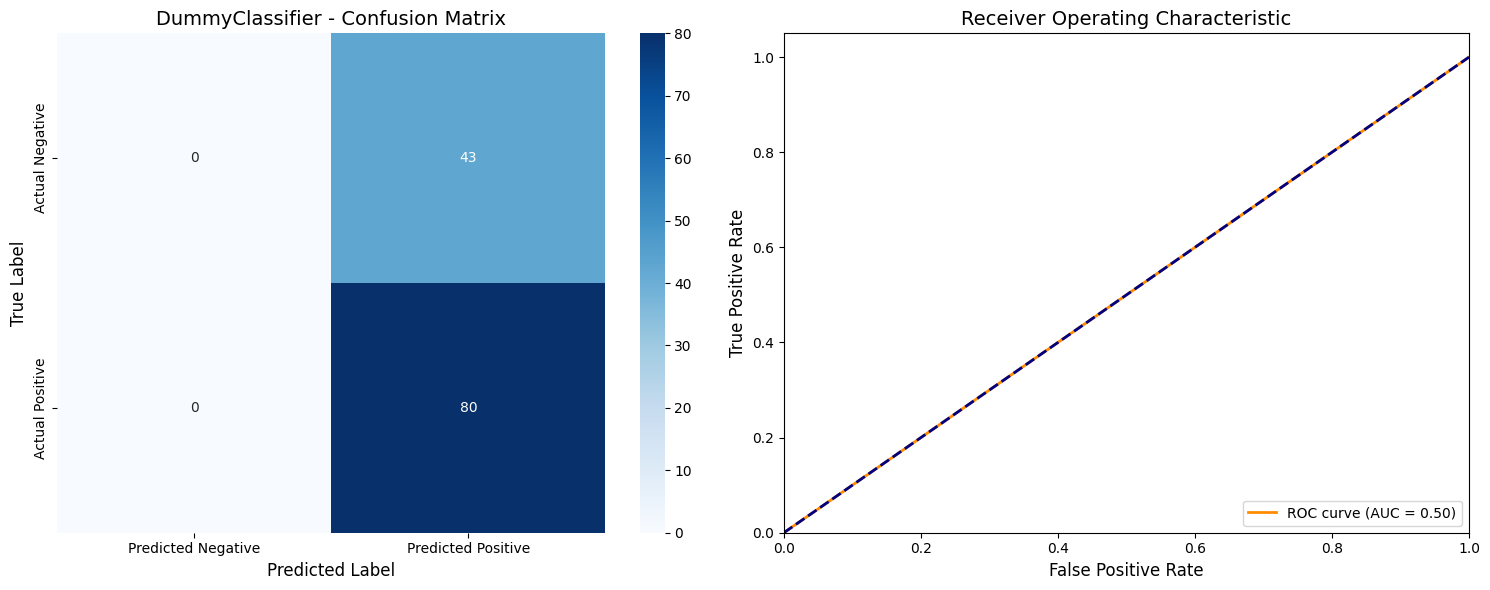


                 DUMMYCLASSIFIER EVALUATION                 

MAIN METRICS:
   Metric  Value
  ROC AUC 0.5000
 F1 Score 0.3941
Precision 0.3252
   Recall 0.5000
 Accuracy 0.6504


CLASSIFICATION REPORT:
   Class  Precision  Recall
Positive   0.650407     1.0
Negative   0.000000     0.0



c:\YandexDisk\IT\DS\loan-prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
# Задаем и обучаем модель
dummy_classifier = DummyClassifier(random_state=SEED, strategy='most_frequent')
dummy_classifier.fit(X_train_preprocessed, y_train)

# Получаем предсказания
y_pred = dummy_classifier.predict(X_test_preprocessed) # предсказываем номер класса
y_probs = dummy_classifier.predict_proba(X_test_preprocessed)[:, 1] # предсказываем вероятность (необходима для построения ROC кривой)

# Считаем метрики для модели и выводим графики
dummy_classifier_metrics = h.evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="DummyClassifier"
)

Как видим, ROC AUC в этом случае ожидаемо равна 0.5 и f1 = 0.39. Тут важно отметить, что для f1 используется macro усреднение, так как важны оба класса (по умолчанию в sklearn используется binary, тогда f1 считается только для положительного класса)

### 6.2 Логистическая регрессия

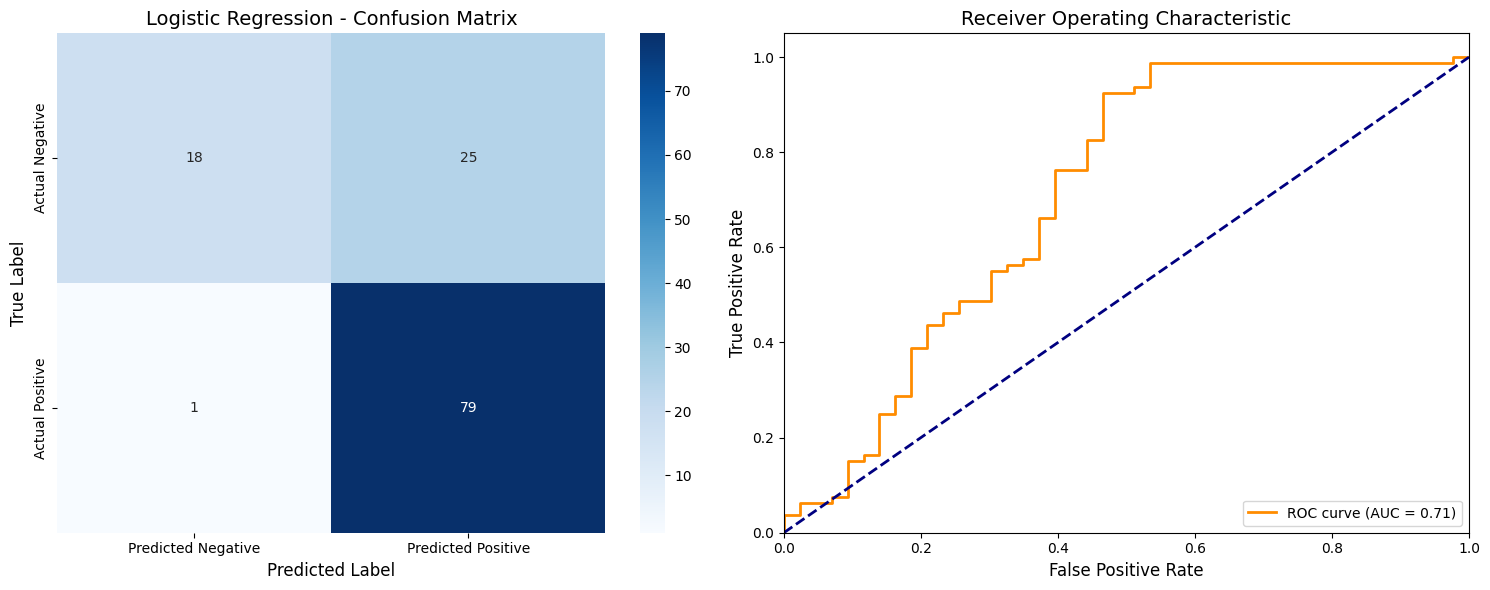


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7116
 F1 Score 0.7197
Precision 0.8535
   Recall 0.7031
 Accuracy 0.7886


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.759615 0.987500
Negative   0.947368 0.418605



In [64]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')
log_reg.fit(X_train_preprocessed, y_train)

y_pred = log_reg.predict(X_test_preprocessed)
y_probs = log_reg.predict_proba(X_test_preprocessed)[:, 1]  

log_reg_metrics = h.evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression"
)

c:\YandexDisk\IT\DS\loan-prediction\helper.py:296: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


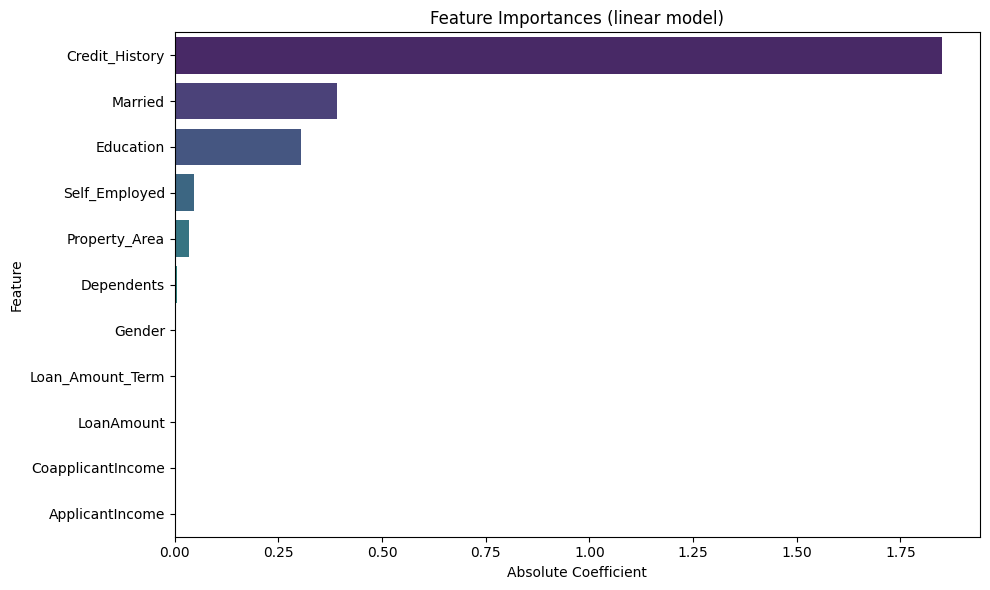

,Feature,Importance
10,Credit_History,1.849521
1,Married,0.391925
2,Education,0.303932
3,Self_Employed,0.046820
4,Property_Area,0.034939
6,Dependents,0.006067
0,Gender,0.002348
7,Loan_Amount_Term,0.002276
5,LoanAmount,0.002156
9,CoapplicantIncome,0.000065


In [65]:
# Построим гистограмму важностей для каждой фичи
h.plot_feature_importance(log_reg, feature_names)

Как видим, в случае логистической регрессии на первом месте оказалась кредитная история, похожую картину мы наблюдали, когда строили матрицу корреляций. 

In [66]:
# также можно визуализировать важность фичей используя библиотеку shap

# import shap
# shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar")
# shap.summary_plot(shap_values, X_test_preprocessed)

### 6.3 Дерево решений

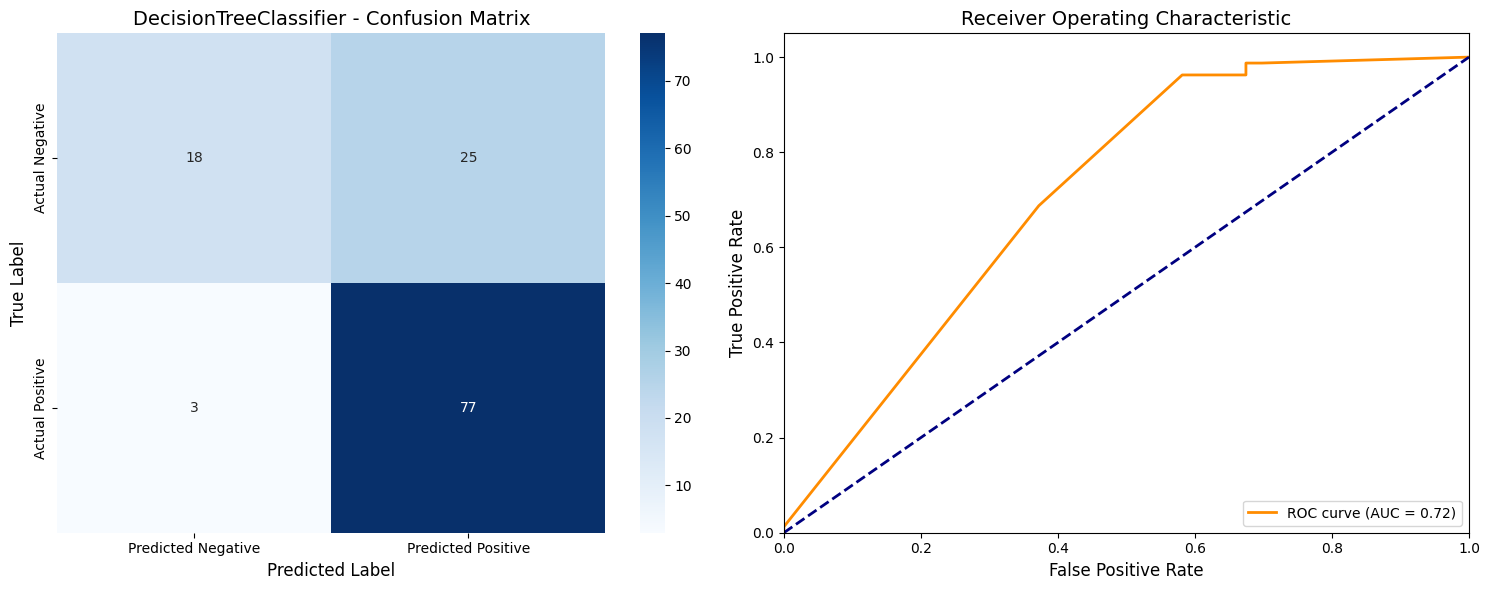


             DECISIONTREECLASSIFIER EVALUATION              

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7158
 F1 Score 0.7043
Precision 0.8060
   Recall 0.6906
 Accuracy 0.7724


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.754902 0.962500
Negative   0.857143 0.418605



In [67]:
decision_tree = DecisionTreeClassifier(random_state=SEED, max_depth=4)
decision_tree.fit(X_train_preprocessed, y_train)

y_pred = decision_tree.predict(X_test_preprocessed)
y_probs = decision_tree.predict_proba(X_test_preprocessed)[:, 1]  # For ROC curve

decision_tree_metrics = h.evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="DecisionTreeClassifier"
)

c:\YandexDisk\IT\DS\loan-prediction\helper.py:296: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


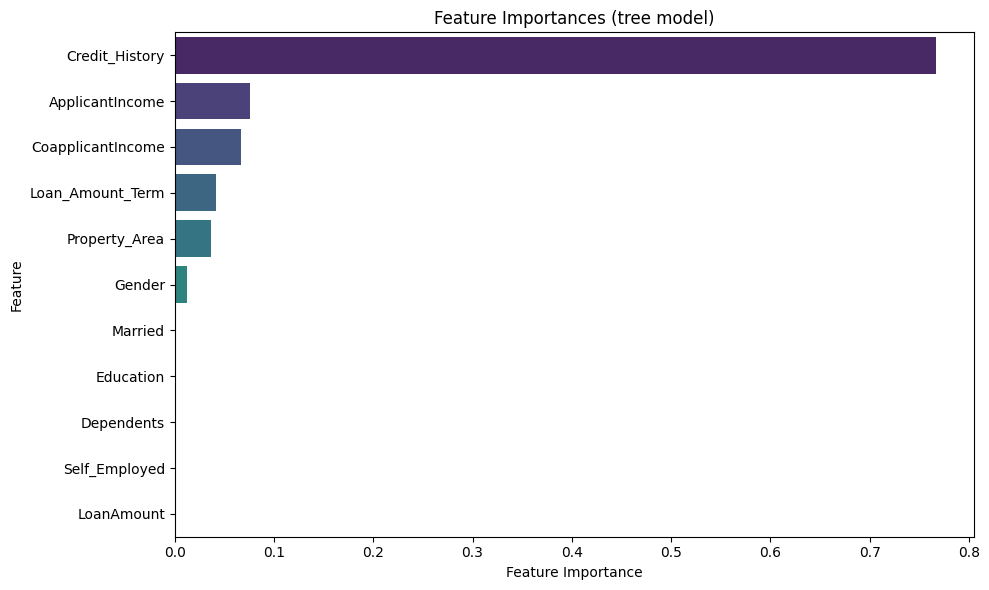

,Feature,Importance
10,Credit_History,0.767285
8,ApplicantIncome,0.075501
9,CoapplicantIncome,0.067093
7,Loan_Amount_Term,0.041055
4,Property_Area,0.036470
0,Gender,0.012595
1,Married,0.000000
2,Education,0.000000
6,Dependents,0.000000
3,Self_Employed,0.000000


In [68]:
h.plot_feature_importance(decision_tree, feature_names)

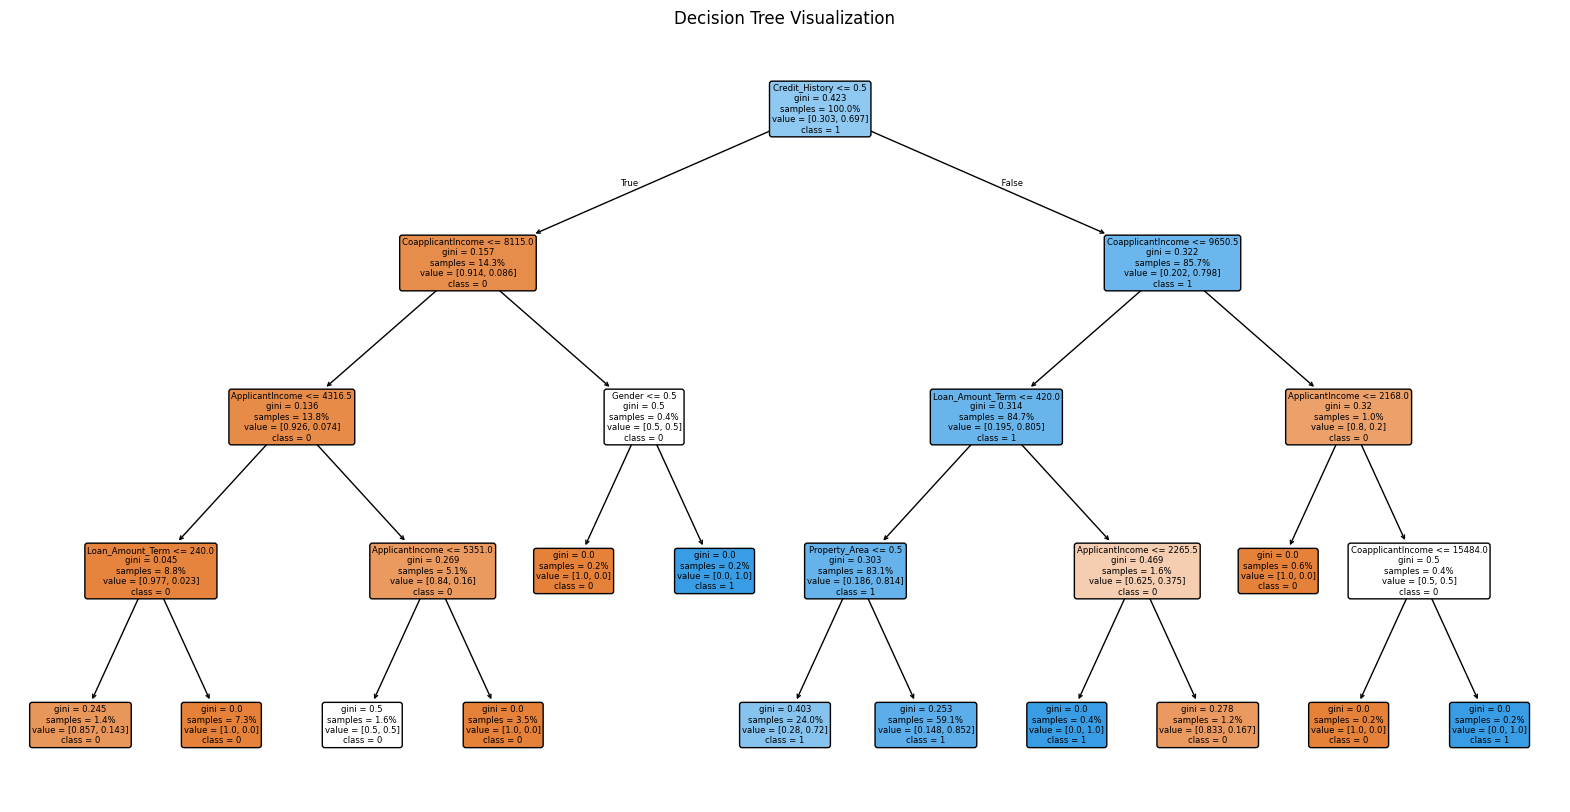

In [69]:
# Визуализируем наше дерево решений
h.visualize_decision_tree(decision_tree, feature_names, class_names=['0', '1'])

Оранжевым цветом изображены вершины с классом 0, синим - с классом 1. Значение value показывает, какая доля семплов в вершине относится к 0 и 1 классам соответственно. Samples показывает, какая доля всех семплов оказалась в этой вершине.

### 6.4 Случайный лес

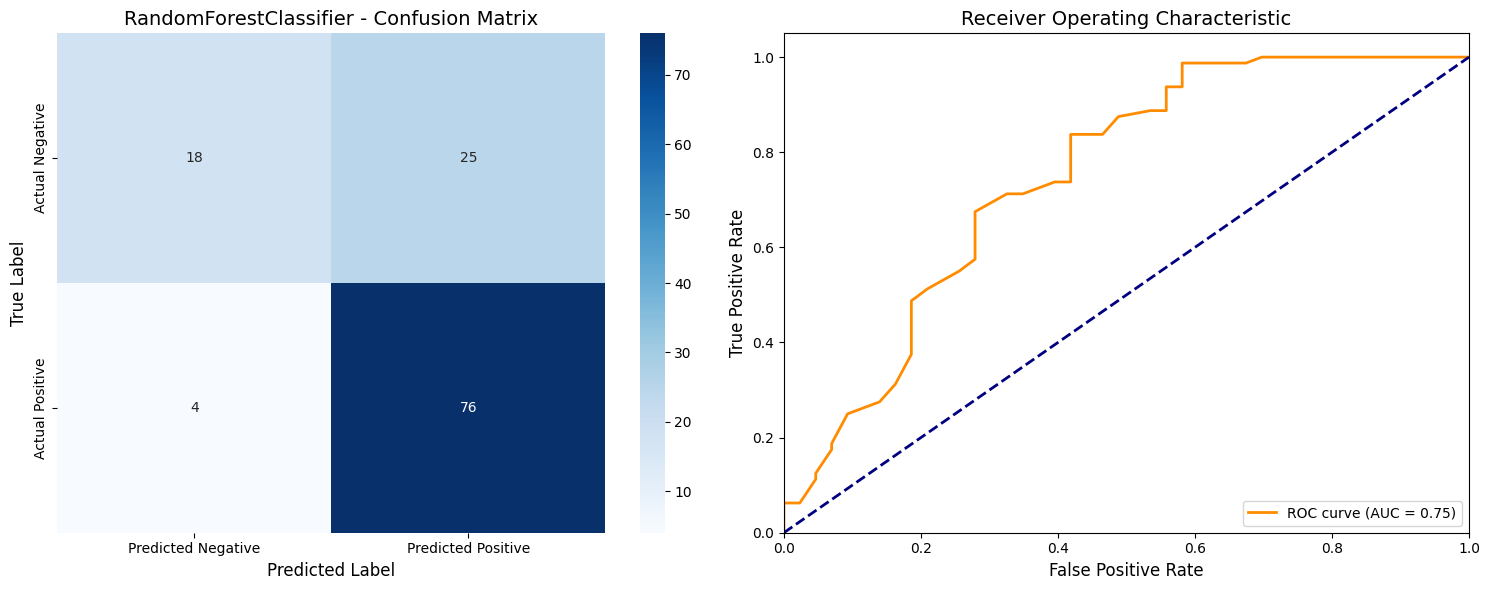


             RANDOMFORESTCLASSIFIER EVALUATION              

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7478
 F1 Score 0.6968
Precision 0.7853
   Recall 0.6843
 Accuracy 0.7642


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.752475 0.950000
Negative   0.818182 0.418605



In [70]:
# Train your model
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train_preprocessed, y_train)

# Get predictions
y_pred = random_forest.predict(X_test_preprocessed)
y_probs = random_forest.predict_proba(X_test_preprocessed)[:, 1]  # For ROC curve

# Evaluate
random_forest_metrics = h.evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="RandomForestClassifier"
)

c:\YandexDisk\IT\DS\loan-prediction\helper.py:296: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


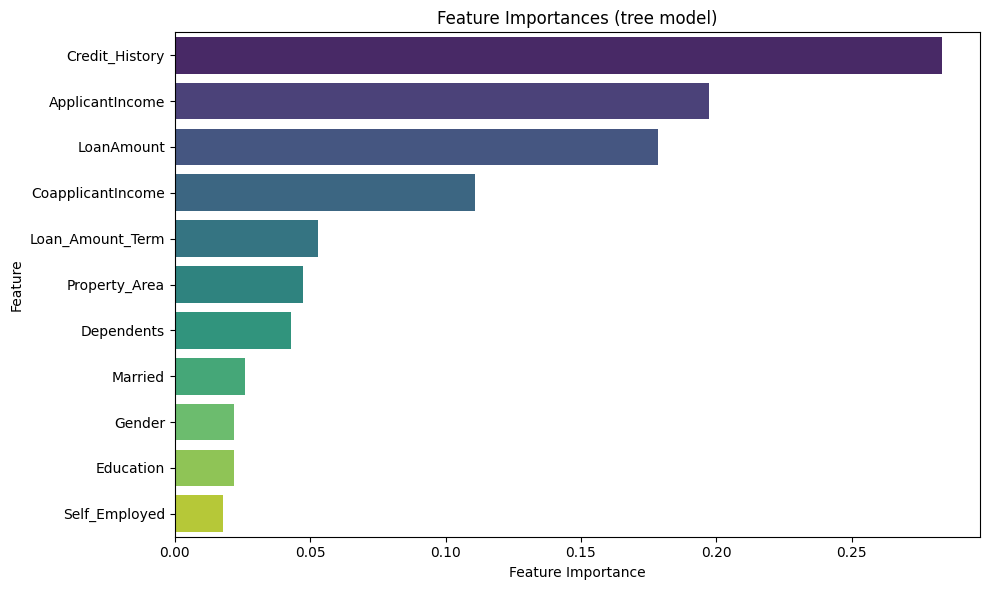

,Feature,Importance
10,Credit_History,0.283222
8,ApplicantIncome,0.197219
5,LoanAmount,0.178566
9,CoapplicantIncome,0.110754
7,Loan_Amount_Term,0.052926
4,Property_Area,0.047293
6,Dependents,0.042799
1,Married,0.025830
0,Gender,0.021866
2,Education,0.021807


In [71]:
h.plot_feature_importance(random_forest, feature_names)

Видим, что в отличие от предыдущих моделей, случайный лес сильнее учитывает фичи помимо Credit_History и разброс важности получается меньше

### 6.5 Градиентный бустинг

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

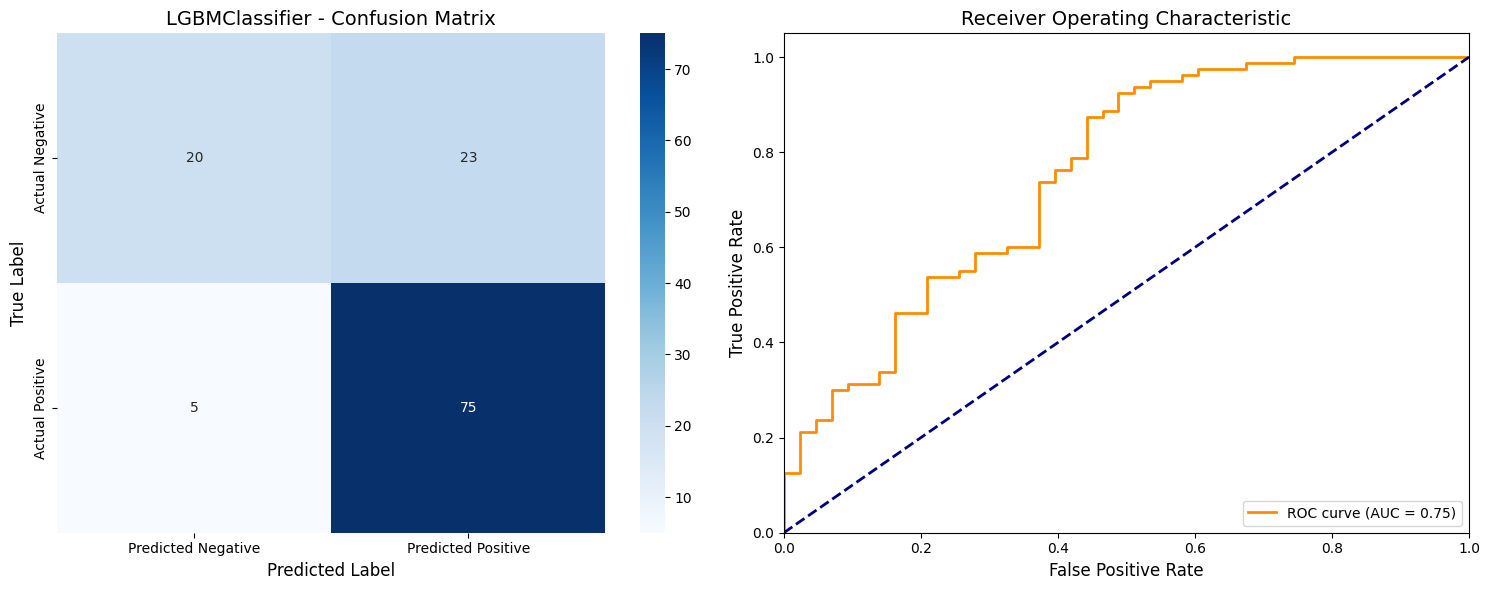


                 LGBMCLASSIFIER EVALUATION                  

MAIN METRICS:
   Metric  Value
  ROC AUC 0.7541
 F1 Score 0.7155
Precision 0.7827
   Recall 0.7013
 Accuracy 0.7724


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.765306 0.937500
Negative   0.800000 0.465116



In [72]:
# Train your model
lgbm = LGBMClassifier(random_state=SEED)
lgbm.fit(X_train_preprocessed, y_train)

# Get predictions
y_pred = lgbm.predict(X_test_preprocessed)
y_probs = lgbm.predict_proba(X_test_preprocessed)[:, 1]  # For ROC curve

# Evaluate
lgbm_metrics = h.evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="LGBMClassifier"
)

c:\YandexDisk\IT\DS\loan-prediction\helper.py:296: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')


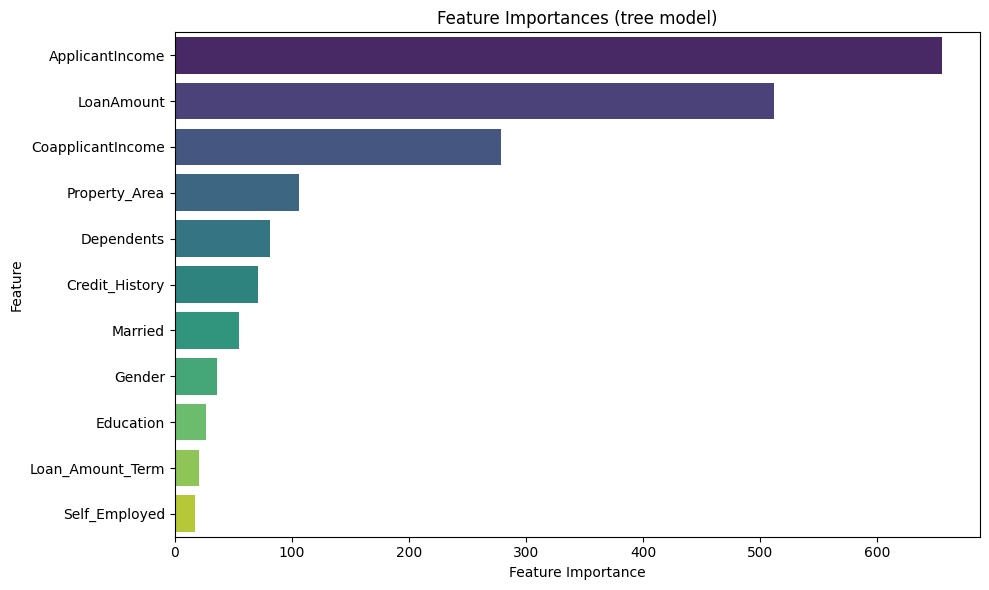

,Feature,Importance
8,ApplicantIncome,655
5,LoanAmount,512
9,CoapplicantIncome,279
4,Property_Area,106
6,Dependents,81
10,Credit_History,71
1,Married,55
0,Gender,36
2,Education,27
7,Loan_Amount_Term,21


In [73]:
h.plot_feature_importance(lgbm, feature_names)

Здесь мы видим сильную разницу по сравнению с другими моделями: теперь в качестве самых важных фич выступают уже ApplicantIncome, LoanAmount и CoapplicantIncome, что в принципе логично и ожидаемо. Credit_History оказывается где-то посередине. Метрики при этом не уступают предыдущим моделям. Это говорит о том, что бустинг лучше справился с задачей выбора наиболее перспективных фич для предсказания и определил важные нелинейные закономерности там, где другие модели их не обнаружили.

### 6.6 Финальное сравнение метрик

In [74]:
final_metrics = {
    'dummy_classifier': dummy_classifier_metrics,
    'log_reg': log_reg_metrics,
    'decision_tree': decision_tree_metrics,
    'random_forest': random_forest_metrics,
    'lgbm': lgbm_metrics
}

result = pd.DataFrame(final_metrics.values(), index=final_metrics.keys())

In [75]:
result

,ROC AUC,F1 Score,Precision,Recall,Accuracy
dummy_classifier,0.500000,0.394089,0.325203,0.500000,0.650407
log_reg,0.711628,0.719670,0.853492,0.703052,0.788618
decision_tree,0.715843,0.704327,0.806022,0.690552,0.772358
random_forest,0.747820,0.696813,0.785329,0.684302,0.764228
lgbm,0.754070,0.715466,0.782653,0.701308,0.772358


<Axes: >

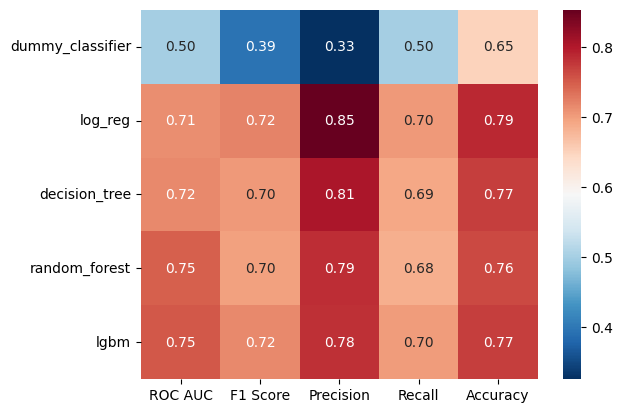

In [76]:
sns.heatmap(result, cmap='RdBu_r', annot=True, fmt=".2f")

В целом, за исключением dummy_classifier, большой разницы между точностью моделей нет, поэтому выбор можно сделать на основе других факторов: оптимальный выбор фич, интерпретируемость, скорость обучения и инференса